# Neural Network Time Series Prediction Model
This notebook contains code to train and analyze a neural network-based model which is able to make predictions for a chosen time series, using inputs from all other observed sensors at the corresponding time.

In [1]:
# Imports
import glob
import keras
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sklearn.utils
import tensorflow as tf
from pprint import pprint

Using TensorFlow backend.


### Read Data
Currently, we read google traffic, buildingdepot, and ion time series values from local flat files. In the future, this can be replaced with code to extract data from other sources, such as a database or REST API.

In [2]:
data_dir = 'data/'
time_series_dfs = []
target_filename = 'gilman1_1.csv'
target_df = None

In [3]:
# Read Google Traffic travel time data
google_traffic_files = sorted(glob.glob(data_dir + 'google_traffic/data/*.csv'))

for filepath in google_traffic_files:
    filename = os.path.basename(filepath)
    df = pd.read_csv(filepath, header=None, names=['time', filename])
    
    if len(df) == 0:
        continue
    if df[filename].std() < 1e-10:
        continue
    
    df['time'] = pd.to_datetime(df['time'])
    df['time'] = df['time'].apply(lambda x: x.replace(microsecond=0, nanosecond=0))
    df = df.set_index('time')
    
    if filename == target_filename:
        target_df = df
    else:
        time_series_dfs.append(df)

In [4]:
# Read Buildingdepot data
buildingdepot_files = sorted(glob.glob(data_dir + 'buildingdepot/data/*.csv'))

for i, filepath in enumerate(buildingdepot_files):
    if i % 1000 == 0:
        print i,
    
    filename = os.path.basename(filepath)
    df = pd.read_csv(filepath)
    df = df.rename(columns={'value': filename})
    
    if len(df) == 0:
        continue
    if df[filename].std() < 1e-10:
        continue
    
    df['time'] = pd.to_datetime(df['time'])
    df = df.set_index('time')

    if filename == target_filename:
        target_df = df
    else:
        time_series_dfs.append(df)

0 1000 2000 3000 4000 5000 6000 7000 8000 9000 10000 11000 12000 13000 14000 15000 16000


In [5]:
# Read ion data
ion_files = sorted(glob.glob(data_dir + 'ion_data/data/*.csv'))

for i, filepath in enumerate(ion_files):
    if i % 100 == 0:
        print i,
    
    filename = os.path.basename(filepath)
    df = pd.read_csv(filepath, header=None, names=['time', filename])
    
    if len(df) == 0:
        continue
    if df[filename].std() < 1e-10:
        continue
    
    df['time'] = pd.to_datetime(df['time'])
    df = df.set_index('time')
    
    if filename == target_filename:
        target_df = df
    else:
        time_series_dfs.append(df)

0 100 200 300 400 500 600 700 800 900


In [6]:
# Normalize sensor readings and find nearest values (in time) for every target reading
for i in range(len(time_series_dfs)):
    if i % 1000 == 0:
        print i,
        
    df = time_series_dfs[i]
    
    filename = df.columns[0]
    df[filename] = (df[filename] - df[filename].mean()) / df[filename].std()
    
    # Find indices in the current feature df which are closest to each reading in target_df
    indices = np.searchsorted(df.index, target_df.index)
    indices[indices == len(df)] = len(df) - 1
    target_df['indices'] = df.index.get_values()[indices]
    
    # Extract corresponding sensor value for each reading in target_df
    merged = pd.merge(target_df, df, left_on='indices', right_index=True)
    time_series_dfs[i] = merged[[filename]]

target_df = target_df.drop('indices', axis=1)

0 1000 2000 3000 4000 5000 6000 7000 8000


### Train Neural Network Prediction Model
Use the Keras neural networks framework to train a model to predict target sensor values using the corresponding readings from all other sensors.

In [7]:
# Create training and test data
all_data = pd.concat([target_df] + time_series_dfs, axis=1)
shuffled_data = all_data.sample(frac=1, random_state=1)
df_train = shuffled_data.iloc[:int(0.8*len(shuffled_data))]
df_test  = shuffled_data.iloc[int(0.8*len(shuffled_data)):]

x_train = df_train.drop(target_filename, axis=1).values
y_train = df_train[target_filename].values.reshape([len(df_train), 1])
x_test = df_test.drop(target_filename, axis=1).values
y_test = df_test[target_filename].values.reshape([len(df_test), 1])

In [8]:
model = keras.models.Sequential()
model.add(keras.layers.Dense(100, activation='relu', input_shape=(8192,)))
model.add(keras.layers.Dense(1, activation='linear'))
model.summary()

model.compile(loss='mse', optimizer='adam')
history = model.fit(x_train, y_train, batch_size=256, epochs=200, verbose=2,
                    validation_data=(x_test, y_test))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               819300    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 819,401.0
Trainable params: 819,401
Non-trainable params: 0.0
_________________________________________________________________
Train on 3325 samples, validate on 832 samples
Epoch 1/200
1s - loss: 25182.5797 - val_loss: 13314.4674
Epoch 2/200
0s - loss: 6955.1327 - val_loss: 3930.4200
Epoch 3/200
0s - loss: 2647.9876 - val_loss: 1817.0172
Epoch 4/200
0s - loss: 1593.7865 - val_loss: 1185.8468
Epoch 5/200
0s - loss: 1075.1534 - val_loss: 853.4182
Epoch 6/200
0s - loss: 863.8199 - val_loss: 732.6267
Epoch 7/200
0s - loss: 746.4229 - val_loss: 661.8308
Epoch 8/200
0s - loss: 677.7812 - val_loss: 608.6485
Epoch 9/200
0s - loss: 633.8224 - val_loss: 56

1s - loss: 218.0487 - val_loss: 400.8191
Epoch 141/200
1s - loss: 212.9902 - val_loss: 407.4849
Epoch 142/200
1s - loss: 206.4212 - val_loss: 382.7986
Epoch 143/200
1s - loss: 204.5955 - val_loss: 391.0278
Epoch 144/200
1s - loss: 203.5498 - val_loss: 391.0127
Epoch 145/200
1s - loss: 202.0987 - val_loss: 384.4008
Epoch 146/200
1s - loss: 205.5653 - val_loss: 410.2303
Epoch 147/200
1s - loss: 204.1571 - val_loss: 398.9786
Epoch 148/200
1s - loss: 204.4845 - val_loss: 413.1579
Epoch 149/200
1s - loss: 209.0947 - val_loss: 398.8737
Epoch 150/200
1s - loss: 206.0570 - val_loss: 398.1749
Epoch 151/200
1s - loss: 196.0476 - val_loss: 405.7365
Epoch 152/200
1s - loss: 200.2620 - val_loss: 406.1189
Epoch 153/200
1s - loss: 201.7917 - val_loss: 403.1029
Epoch 154/200
1s - loss: 200.8920 - val_loss: 400.7621
Epoch 155/200
1s - loss: 198.1695 - val_loss: 405.9752
Epoch 156/200
1s - loss: 194.2169 - val_loss: 399.3317
Epoch 157/200
1s - loss: 192.7884 - val_loss: 392.6537
Epoch 158/200
1s - loss:

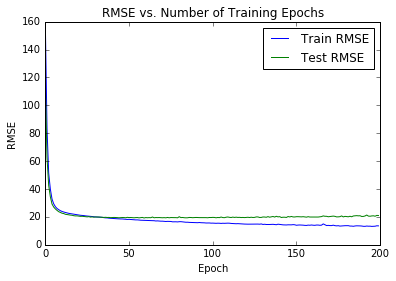

In [9]:
# Plot training and test error for each epoch
train_rmse = [np.sqrt(x) for x in history.history['loss']]
test_rmse = [np.sqrt(x) for x in history.history['val_loss']]

plt.plot(train_rmse, label='Train RMSE')
plt.plot(test_rmse, label='Test RMSE')
plt.legend(loc='best')
plt.title('RMSE vs. Number of Training Epochs')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.show()

### Anomaly Detection
Plot and highlight all anomalies, defined as the points in the test data with highest prediction error. Currently, we highlight as anomalies points which are at least 3 standard deviations above or below the average test error.

Anomaly Locations:
[Timestamp('2016-12-31 07:19:59'),
 Timestamp('2017-01-11 00:57:54'),
 Timestamp('2017-01-13 01:27:57'),
 Timestamp('2017-01-17 06:55:41'),
 Timestamp('2017-01-17 18:58:04'),
 Timestamp('2017-01-18 16:21:55'),
 Timestamp('2017-01-25 01:32:59')]


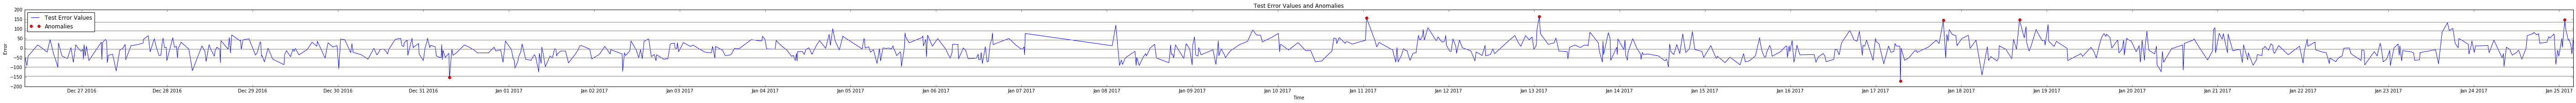

In [10]:
df_test = df_test.sort_index()
df_test['prediction'] = model.predict(x_test)
errors = df_test[target_filename] - df_test['prediction']

fig = plt.figure(figsize=(100, 3))
plt.plot(errors.index, errors, label='Test Error Values')

mean = np.mean(errors)
std = np.std(errors)
plt.axhline(y=mean, color='grey')
plt.axhline(y=mean + 1*std, color='gray')
plt.axhline(y=mean + 2*std, color='gray')
plt.axhline(y=mean + 3*std, color='gray')
plt.axhline(y=mean - 1*std, color='gray')
plt.axhline(y=mean - 2*std, color='gray')
plt.axhline(y=mean - 3*std, color='gray')

max_cutoff = mean + 3*std
min_cutoff = mean - 3*std
anomalies_x = []
anomalies_y = []
for i, error in enumerate(errors):
    if error > max_cutoff or error < min_cutoff:
        anomalies_x.append(errors.index[i])
        anomalies_y.append(error)

print 'Anomaly Locations:'
pprint(anomalies_x)

plt.plot(mdates.date2num(anomalies_x), anomalies_y, 'o', color='red', label='Anomalies')
fig.gca().xaxis.set_major_locator(mdates.DayLocator())
fig.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d %Y'))

plt.title('Test Error Values and Anomalies')
plt.xlabel('Time')
plt.ylabel('Error')
plt.legend(loc='best')
plt.show()

df_test = df_test.drop('prediction', axis=1)

### Model Interpretation
Find the features most highly predictive of the target time series. This is done by iteratively removing (setting to 0) one feature at a time and evaluating the model on the test data. The most predictive features are those for which the test error increases the most after removing.

In [11]:
column_results = []
for i, column in enumerate(df_test.columns):
    if i % 100 == 0:
        print i,
    if column == target_filename:
        continue
    
    df_test_copy = df_test.copy()
    df_test_copy[column] = 0
    x_test = df_test_copy.drop(target_filename, axis=1).values
    y_test = df_test_copy[target_filename].values.reshape([len(df_test), 1])
    
    test_rmse = np.sqrt(model.evaluate(x_test, y_test, verbose=0, batch_size=len(df_test)))
    column_results.append((column, test_rmse))

column_results.sort(key=lambda x: x[1], reverse=True)
print '\n'
print '20 most highly predictive features, with corresponding test RMSE:'
pprint(column_results[:20])

0 100 200 300 400 500 600 700 800 900 1000 1100 1200 1300 1400 1500 1600 1700 1800 1900 2000 2100 2200 2300 2400 2500 2600 2700 2800 2900 3000 3100 3200 3300 3400 3500 3600 3700 3800 3900 4000 4100 4200 4300 4400 4500 4600 4700 4800 4900 5000 5100 5200 5300 5400 5500 5600 5700 5800 5900 6000 6100 6200 6300 6400 6500 6600 6700 6800 6900 7000 7100 7200 7300 7400 7500 7600 7700 7800 7900 8000 8100 

20 most highly predictive features, with corresponding test RMSE:
[('voigt2_1.csv', 21.786831943689705),
 ('gilman1_2.csv', 21.487386862749343),
 ('voigt1_1.csv', 21.361750193696459),
 ('506_1_3000636.csv', 21.180769579975134),
 ('voigt2_2.csv', 21.172078239338155),
 ('1f0be7d1-29a4-43af-8dd9-9a7e90fa9670.csv', 21.154768515798779),
 ('505_1_3001493.csv', 21.147735460041357),
 ('506_3_3001855.csv', 21.131200839653701),
 ('445a8ec1-be21-4feb-83c1-9374462713e4.csv', 21.126445291951701),
 ('423e1021-283a-43d5-bbd8-edde95bff536.csv', 21.118519889523952),
 ('506_1_3003183.csv', 21.101467772140207),
